In [9]:
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pfits
from scipy import sparse
import scipy.sparse
import pickle

from hcipy import *
from scipy.ndimage import center_of_mass

import os
import importlib.util

# Automatically detect where OOPAO is installed
import os, sys
os.chdir("/Users/mayragutierrez/keckAOSim/keckSim")
sys.path.insert(0, os.path.join(os.getcwd(), "simulations_codes"))
os.environ["OOPAO_PATH"]="/Users/mayragutierrez/OOPAO"
sys.path.insert(0, "/Users/mayragutierrez/OOPAO")


# Now import safely
import OOPAO
print("Loaded OOPAO from:", OOPAO.__file__)


from OOPAO.DeformableMirror import DeformableMirror as DM_OOPAO
from OOPAO.MisRegistration import MisRegistration
from OOPAO.Source import Source
from OOPAO.Detector import Detector as Det_OOPAO
from OOPAO.Telescope import Telescope
from OOPAO.Zernike import Zernike
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
from OOPAO.calibration.getFittingError import *
from OOPAO.calibration.CalibrationVault import CalibrationVault
from OOPAO.OPD_map import OPD_map
from OOPAO.ShackHartmann import ShackHartmann

from keckTel import keckTel  # now Python will find this module
from keckAtm import keckAtm

import importlib
from KAO_parameter_file import initializeParameterFile
from simulations_codes.Jitter_TT import RandomTipTilt_Gaussian, SinusoidalTipTilt
from simulations_codes.SH import ShackHartmann_modifNoise
from simulations_codes.Imat_SHWFS import InteractionMatrix_test

from simulations_codes.ZWFS_toolbox.wfSensors import *


Loaded OOPAO from: /Users/mayragutierrez/OOPAO/OOPAO/__init__.py


# **Create Aperture and telescope**

In [10]:
    param = initializeParameterFile()

# -----------------------  Keck apperture ----------------------------------
    keck_object = keckTel.create('keck', resolution=param['resolution'],samplingTime=param['samplingTime'], return_segments=True)

OOPAO Warning: 
User-defined pupil, the central obstruction will not be taken into account...

------------ Telescope -------------
Diameter [m]             |  10.93   
Resolution [px]          |   480    
Pixel size [m]           |   0.02   
Surface [m²]             |  71.63   
Central obstruction [%]  |    0     
Pixels in pupil          |  138152  
Field of view [arcsec]   |   0.00   
------------------------------------



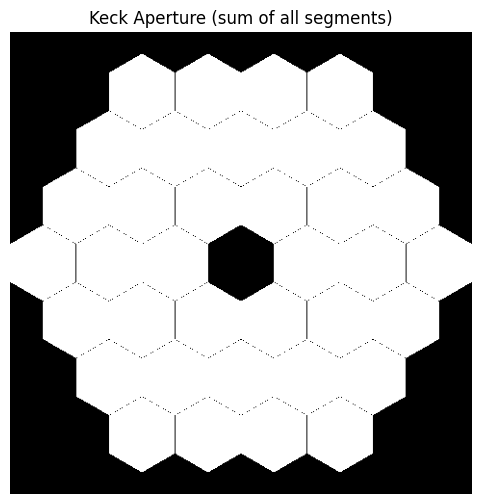

In [16]:
# --------------- 1️⃣ Keck aperture -----------------
res = param['resolution']  # or keck_object.resolution if that exists
keck_pupil = np.sum(keck_object.keck_segments, axis=0).reshape(res, res)

plt.figure(figsize=(6,6))
plt.imshow(keck_pupil, origin='lower', cmap='gray')
plt.title("Keck Aperture (sum of all segments)")
plt.axis('off')
plt.show()

In [11]:
    # -----------------------      KSM       ----------------------------------
    KSM = SegmentedDeformableMirror(keck_object.keck_segments)
    s1 = np.array(KSM.segments)
    seg_vect2D = s1.reshape(s1.shape[0],int(np.sqrt(s1.shape[1])),int(np.sqrt(s1.shape[1])))
    segments_vect1D = seg_vect2D.reshape(seg_vect2D.shape[0],seg_vect2D.shape[1]**2)
    proj_seg = np.linalg.pinv(segments_vect1D)

In [27]:
    # -----------------------     TELESCOPE   ----------------------------------
    tel = keck_object.tel

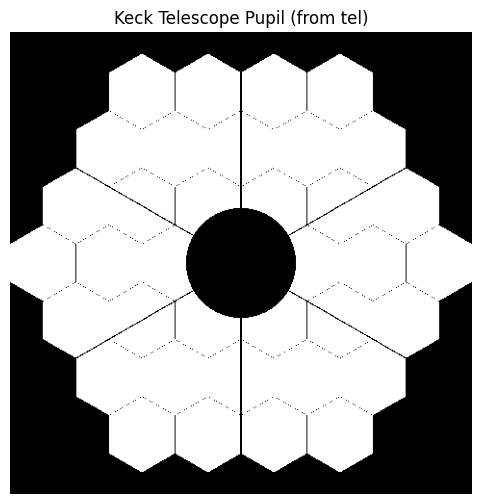

In [20]:
# Try to find the pupil mask
if hasattr(tel, 'pupil'):
    pupil = tel.pupil
elif hasattr(tel, 'phase'):
    pupil = np.abs(tel.phase) > 0  # fallback guess
else:
    raise AttributeError("Telescope object has no visible pupil or phase array.")

# Handle both 1D (flattened) or 2D
if pupil.ndim == 1:
    res = int(np.sqrt(len(pupil)))
    pupil = pupil.reshape(res, res)

plt.figure(figsize=(6,6))
plt.imshow(pupil, origin='lower', cmap='gray')
plt.title("Keck Telescope Pupil (from tel)")
plt.axis('off')
plt.show()

# **Setting Up Natural Guide Star**

In [21]:
    # -----------------------     NGS        ----------------------------------
    ngs=Source(optBand   = param['opticalBand_guide'],\
               magnitude = param['magnitude_guide'], \
               coordinates=param['ngs_coordinate'])
    
    science=Source(optBand   = param['science_opticalBand'],\
                   magnitude = param['science_magnitude'],\
                   coordinates = param['science_coordinate'])
    
    LD_mas = science.wavelength/tel.D * 206265 * 1000 # in mas
    ngs*tel


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 6.4e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 1.1e+08 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 1.9e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------




------------ Telescope -------------
Diameter [m]             |  10.93   
Resolution [px]          |   480    
Pixel size [m]           |   0.02   
Surface [m²]             |  71.63   
Central obstruction [%]  |    0     
Pixels in pupil          |  138152  
Field of view [arcsec]   |   0.00   
Source NGS [m]           | 6.40e-07 
------------------------------------

In [22]:
    # -----------------------     Atmosphere   ----------------------------------
    atm_ = keckAtm.create(telescope=tel,\
                            atm_type='custom',\
                            r0 = param['r0'],\
                            L0 = param['L0'],\
                            wind_speeds = param['windSpeed'],\
                            fractional_r0 = param['fractionnalR0'],\
                            wind_directions = param['windDirection'],\
                            altitudes = param['altitude']) 
    atm = atm_.atm
    atm.update()

Creation of layer1/7 ...
-> Computing the initial phase screen...
initial phase screen : 0.06456804275512695 s
ZZt.. : 13.74671220779419 s
ZXt.. : 1.3183977603912354 s
XXt.. : 0.6279072761535645 s
Done!
Creation of layer2/7 ...
-> Computing the initial phase screen...
initial phase screen : 0.055142879486083984 s
ZZt.. : 0.0 s
ZXt.. : 1.0967254638671875e-05 s
XXt.. : 1.0013580322265625e-05 s
SCAO system considered: covariance matrices were already computed!
Done!
Creation of layer3/7 ...
-> Computing the initial phase screen...
initial phase screen : 0.059676170349121094 s
ZZt.. : 0.0 s
ZXt.. : 6.198883056640625e-06 s
XXt.. : 4.76837158203125e-06 s
SCAO system considered: covariance matrices were already computed!
Done!
Creation of layer4/7 ...
-> Computing the initial phase screen...
initial phase screen : 0.048568010330200195 s
ZZt.. : 1.9073486328125e-06 s
ZXt.. : 6.9141387939453125e-06 s
XXt.. : 2.1457672119140625e-06 s
SCAO system considered: covariance matrices were already compu

In [25]:
    # -----------------------     DEFORMABLE MIRRORs   ----------------------------------
    nAct = param['nActuator']
    pitch = param['diameter']/(param['nActuator']-1)
    # mis-registrations object
    misReg = MisRegistration(param)
    
    dm = DM_OOPAO(telescope=tel,
                          nSubap=nAct-1,
                          mechCoupling=param['mechanicalCoupling'],
                          misReg=misReg,
                          coordinates=param['dm_coordinates'],
                          pitch=pitch,
                          floating_precision=32)

    pup = tel.pupil.flatten()
    IF = dm.modes.astype(np.float32) * pup[:, np.newaxis]
    IF_sum = np.sum(IF, axis=0)
    IF_max = IF_sum.max()
    valid_index = np.where(IF_sum >= param['validActTreshold']*IF_max)[0]
    IF_filtered = IF[:, valid_index]
    dm_modes = IF_filtered
    
    DM = DM_OOPAO(telescope=tel,
                          nSubap=nAct-1,
                          mechCoupling=param['mechanicalCoupling'],
                          misReg=misReg,
                          coordinates=param['dm_coordinates'],
                          pitch=pitch, 
                          modes=IF_filtered)
    dm_modes = DM.modes
    projector_DM = np.linalg.pinv(dm_modes)


No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   357   
M4                       |  False  
Pitch [m]                |  0.55   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Loading the 2D zonal modes...
Done!

-------- Deformable mirror --------
Controlled Actuators     |   298   
M4                       |  False  
Pitch [m]                |  0.55   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [

In [26]:
    #  -----------------------     TTM basis  ----------------------------------
    Z = Zernike(tel, param['nb_Zpolynomials'])
    Z.computeZernike(tel)
    TT_modes = Z.modesFullRes[:,:,:2].reshape(param['resolution']**2, Z.modesFullRes[:,:,:2].shape[-1])

    TTM = DM_OOPAO(telescope=tel,
                           nSubap=2,
                           mechCoupling=param['mechanicalCoupling'],
                           modes=TT_modes)

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Loading the 2D zonal modes...
Done!

-------- Deformable mirror --------
Controlled Actuators     |    2    
M4                       |  False  
Pitch [m]                |  5.46   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------

